In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import re
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [2]:
survived_train = df_train.Survived

In [21]:
data = pd.concat([df_train.drop(['Survived'], axis=1), df_test])

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [23]:
data['Age'] = data['Age'].fillna(data['Age'].median())
data['Fare'] = data['Fare'].fillna(data['Fare'].median())
#df_train['Age'].fillna(df_train['Age'].median())
data = pd.get_dummies(data, columns=['Sex'], drop_first=True)
data = data[['Sex_male', 'Fare', 'Age','Pclass', 'SibSp']]
data.head()

,Sex_male,Fare,Age,Pclass,SibSp
0,1,7.2500,22.0,3,1
1,0,71.2833,38.0,1,1
2,0,7.9250,26.0,3,0
3,0,53.1000,35.0,1,1
4,1,8.0500,35.0,3,0


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 5 columns):
Sex_male    1309 non-null uint8
Fare        1309 non-null float64
Age         1309 non-null float64
Pclass      1309 non-null int64
SibSp       1309 non-null int64
dtypes: float64(2), int64(2), uint8(1)
memory usage: 52.4 KB


In [13]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=3)

In [25]:
data_train = data.iloc[:891]
data_test = data.iloc[891:]

X = data_train.values
test = data_test.values
y = survived_train.values

In [26]:
clf = clf.fit(X, y)

In [29]:
Y_pred = clf.predict(test)
df_test['Survived'] = Y_pred

In [30]:
df_test[['PassengerId', 'Survived']].to_csv('sub_?_decision_tree.csv', index=False)

Accuracy on Kaggle 77.9. Small improvement. What was this model?

## What was this decision tree classifier?

In [31]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=['Sex_male', 'Fare', 'Age', 'Pclass','SibSp'],  
                         class_names=['Dead', 'Survived'],  
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("titanic_dt") 

'titanic_dt.pdf'

## Why would you choose max_depth=3 ?

The depth of the tree is known as a hyperparameter, which means a parameter we need to decide before we fit the model to the data.

If we choose a larger max_depth, we'll get a more complex decision boundary. If our decision boundary is _too complex_ we can overfit to the data, which means that our model will be describing noise as well as signal.

If our max_depth is too small, we may be underfitting the data, meaning that our model doesn't contain enough of the signal.

How do we tell whether we're overfitting or underfitting?

One way is to hold out a test set from our training data. We can then fit the model to our training data, make predictions on our test set and see how well our prediction does on the test set. Let's now do this:

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y)

In [35]:
import numpy as np

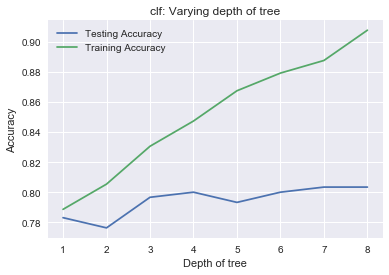

In [45]:
# Setup arrays to store train and test accuracies
dep = np.arange(1, 9)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Loop over different values of k
for i, k in enumerate(dep):
    # Setup a k-NN Classifier with k neighbors: knn
    clf = tree.DecisionTreeClassifier(max_depth=k)

    # Fit the classifier to the training data
    clf.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = clf.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = clf.score(X_test, y_test)

# Generate plot
plt.title('clf: Varying depth of tree')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

In [43]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X, y)
Y_pred = clf.predict(test)
df_test['Survived'] = Y_pred

In [44]:
df_test[['PassengerId', 'Survived']].to_csv('sub_??_decision_tree.csv', index=False)

Same _accuracy_ on kaggle.

## Cross validation

In [48]:
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
dep = np.arange(1, 9)
param_grid = {'max_depth': dep}
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X, y)

# Print the tuned parameter and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameters: {'C': 0.43939705607607948}
Best score is 0.7912457912457912


In [49]:
Y_pred = logreg_cv.predict(test)
df_test['Survived'] = Y_pred

In [50]:
df_test[['PassengerId', 'Survived']].to_csv('sub_?_logreg.csv', index=False)

_Accuracy_ was 76

In [52]:
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
dep = np.arange(1, 9)
param_grid = {'max_depth': dep}

# Instantiate a logistic regression classifier: logreg
clf = tree.DecisionTreeClassifier()

# Instantiate the GridSearchCV object: logreg_cv
clf_cv = GridSearchCV(clf, param_grid, cv=5)

# Fit it to the data
clf_cv.fit(X, y)

# Print the tuned parameter and score
print("Tuned Decision Tree Parameters: {}".format(clf_cv.best_params_))
print("Best score is {}".format(clf_cv.best_score_))


Tuned Decision Tree Parameters: {'max_depth': 8}
Best score is 0.819304152637486


In [53]:
Y_pred = clf_cv.predict(test)
df_test['Survived'] = Y_pred

In [54]:
df_test[['PassengerId', 'Survived']].to_csv('sub_cv_dt.csv', index=False)

_Accuracy_ was 78.4 on kaggle.